In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


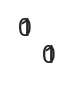

In [2]:
mpl.rcParams['figure.dpi'] = 180
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [5]:
cedar_related = pd.read_csv('../data/220920_cedar_related_scored.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/220920_cedar_related_scored.csv'

In [ ]:
cedar_related_baseline.query('mutation_type!="substitution"').groupby(['anchor_mutation','binder']).count()

3480


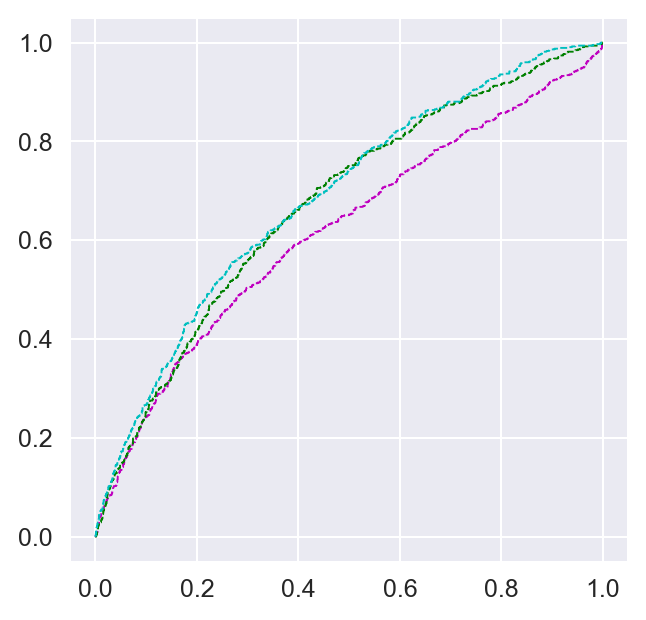

In [6]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

# Various checks

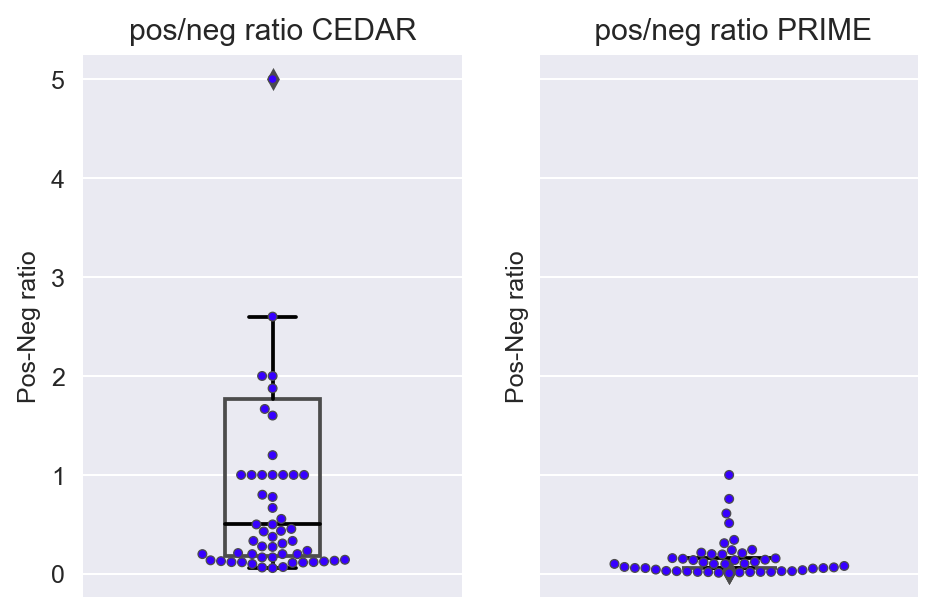

In [133]:
# POS-NEG ratio boxplot
f,a = plt.subplots(1,2, figsize=(6,4), sharey=True)
pd.options.display.max_rows=999
gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
# sorted_ratios.plot(kind='box', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
# sorted_ratios.plot(kind='swarm', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)

sns.boxplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[0], saturation=1,
           width=0.25, boxprops={'facecolor':'none'})
plt.setp(a[0].artists, edgecolor = 'k', facecolor='w')
plt.setp(a[0].lines, color='k')
sns.swarmplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[0], size=3.5, linewidth=0.5 )
a[0].set_title('pos/neg ratio CEDAR')
a[0].set_xlabel('')
# PRIME
gb_count = prime.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = prime.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
# sorted_ratios.plot(kind='box', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
# sorted_ratios.plot(kind='swarm', title = 'Boxplot of Positive to Negative ratio for all HLAs in CEDAR', ax = a)

sns.boxplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[1], saturation=1,
           width=0.25, boxprops={'facecolor':'none'})
plt.setp(a[1].artists, edgecolor = 'k', facecolor='w')
plt.setp(a[1].lines, color='k')
sns.swarmplot(data=sorted_ratios, y = 'Pos-Neg ratio',  ax =a[1], size=3.5, linewidth=0.5 )
a[1].set_title(' pos/neg ratio PRIME')
a[1].set_xlabel('')
pd.options.display.max_rows=10 

Text(0.5, 1.0, 'Pos-Neg ratio vs n_pos per HLA for CEDAR')

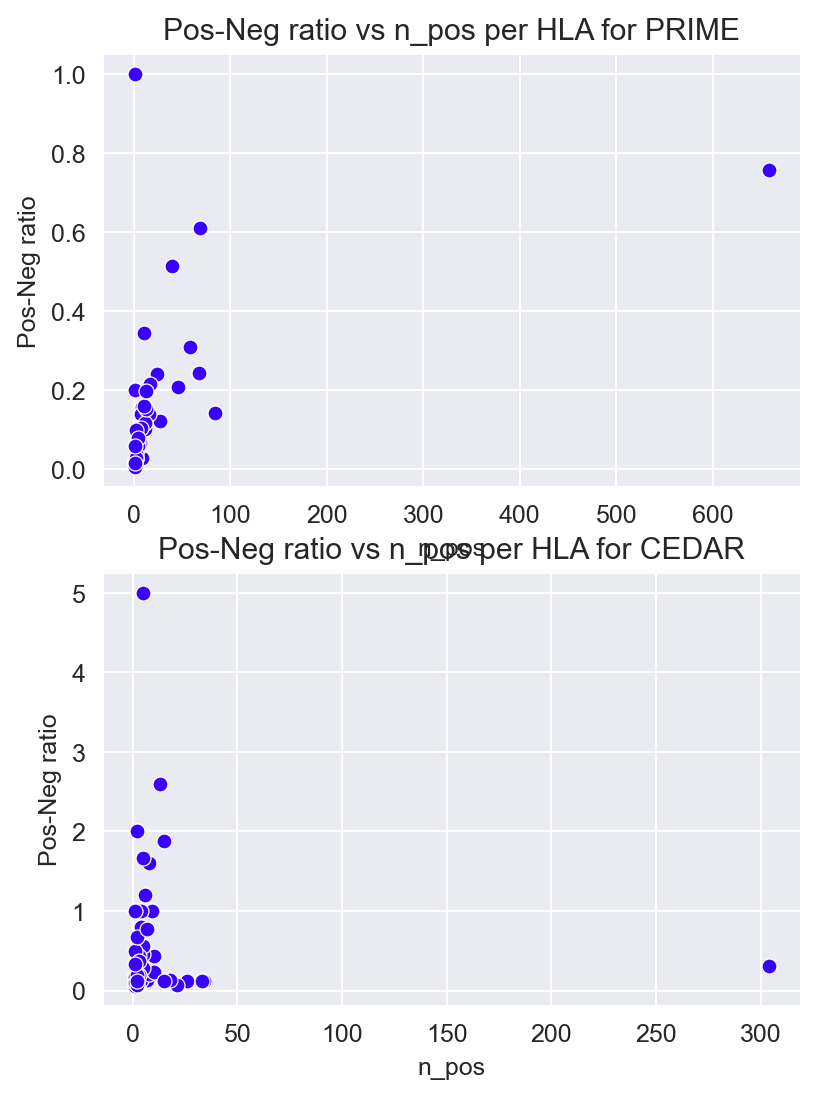

In [137]:
f,a = plt.subplots(2,1, figsize=(5,7))


gb_count = prime.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = prime.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios, left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= 'Pos-Neg ratio', linewidth=0.5, ax = a[0])

a[0].set_title('Pos-Neg ratio vs n_pos per HLA for PRIME')


gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)

npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios, left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= 'Pos-Neg ratio', linewidth=0.5, ax = a[1])

a[1].set_title('Pos-Neg ratio vs n_pos per HLA for CEDAR')


In [ ]:
f,a = plt.subplots(1,1, figsize=(5,3.5))
npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios, left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= 'Pos-Neg ratio', linewidth=0.5)

max_x = npos_ratios.iloc[npos_ratios['n_pos'].argmax()].name
max_y = npos_ratios.iloc[npos_ratios['Pos-Neg ratio'].replace(np.inf, 0).argmax()].name
# label outlier in x
a.text(npos_ratios.loc[max_x]['n_pos']-30, npos_ratios.loc[max_x]['Pos-Neg ratio']+0.2, max_x)
# label outlier in y
a.text(npos_ratios.loc[max_y]['n_pos']+5, npos_ratios.loc[max_y]['Pos-Neg ratio']-0.2, max_y)
a.set_title('Pos-Neg ratio vs number of positive peptides in dataset per HLA for PRIME')

In [7]:
dataset = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')
gb = dataset.groupby(['anchor_mutation', 'binder', 'agg_label']).agg(count=('Peptide','count'))
gb['proportion'] = gb.groupby(['anchor_mutation', 'binder']).apply(lambda x: x/np.sum(x))
gb

count  proportion
anchor_mutation binder    agg_label                   
0               Conserved 0           1191    0.788742
                          1            319    0.211258
                Improved  0            155    0.807292
                          1             37    0.192708
1               Conserved 0            701    0.867574
                          1            107    0.132426
                Improved  0            394    0.753346
                          1            129    0.246654

In [8]:
print('Normal KL Weighting for HLA A0201, Length 9\n\t', [x.round(3) for x in 1 - ics_kl[9]['HLA-A0201'][0.25]])

print('"Inverted" KL Weighting for HLA A0201, Length 9\n\t', [x.round(3) for x in ics_kl[9]['HLA-A0201'][0.25]])
print('Anchor positions\n\t', [x>.1617 for x in ics_kl[9]['HLA-A0201'][0.25]])

Normal KL Weighting for HLA A0201, Length 9
	 [0.883, 0.335, 0.921, 0.838, 0.958, 0.878, 0.933, 0.924, 0.434]
"Inverted" KL Weighting for HLA A0201, Length 9
	 [0.117, 0.665, 0.079, 0.162, 0.042, 0.122, 0.067, 0.076, 0.566]
Anchor positions
	 [False, True, False, True, False, False, False, False, True]


In [9]:
features = pd.Index(['trueHLA_EL_rank', 'wt_EL_rank', 'anchor_mutation', 'mutation_score'])
deltas = pd.Index([x for x in dataset.columns if x.startswith('delta_') or 'ratio' in x])
feature_columns = features.join(deltas, 'outer', sort=False)
feature_columns, len(feature_columns)

(Index(['anchor_mutation', 'delta_VHSE1', 'delta_VHSE3', 'delta_VHSE7',
        'delta_VHSE8', 'delta_aliphatic_index', 'delta_boman',
        'delta_hydrophobicity', 'delta_isoelectric_point', 'delta_rank',
        'mutation_score', 'rank_ratio', 'trueHLA_EL_rank', 'wt_EL_rank'],
       dtype='object'),
 14)

## KL weighting checks

In [156]:
list(cedar_related.BinderMutation.unique())+['All']

['Conserved Binder, Non-Anchor',
 'Improved Binder, Non-Anchor',
 'Improved Binder, Anchor',
 'Conserved Binder, Anchor',
 'All']

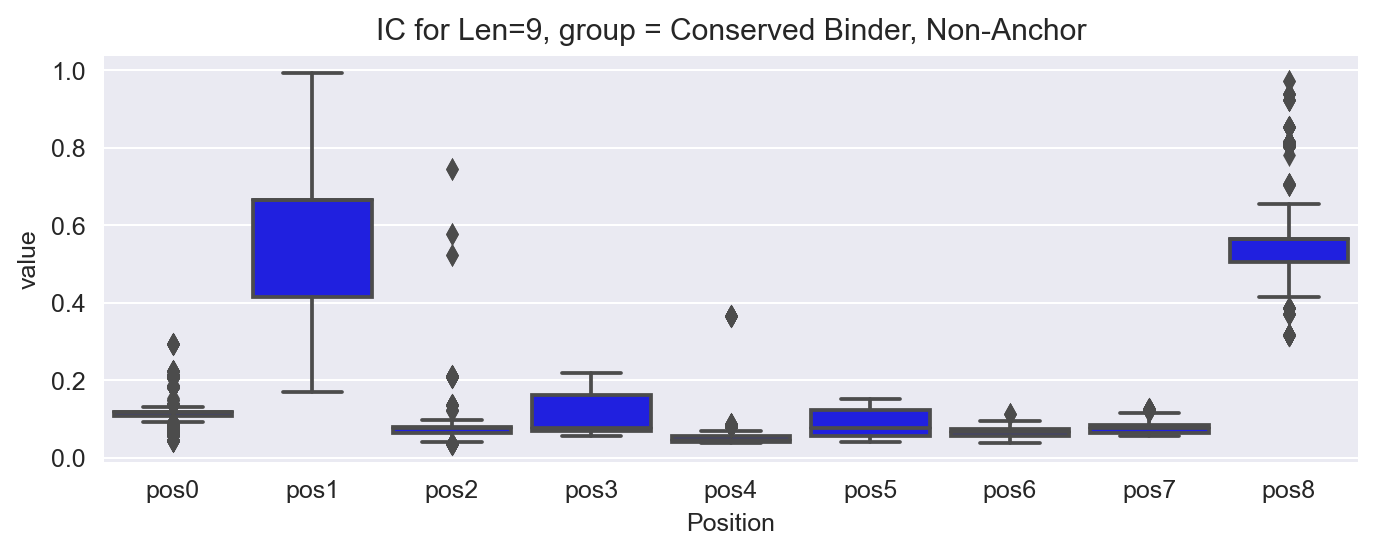

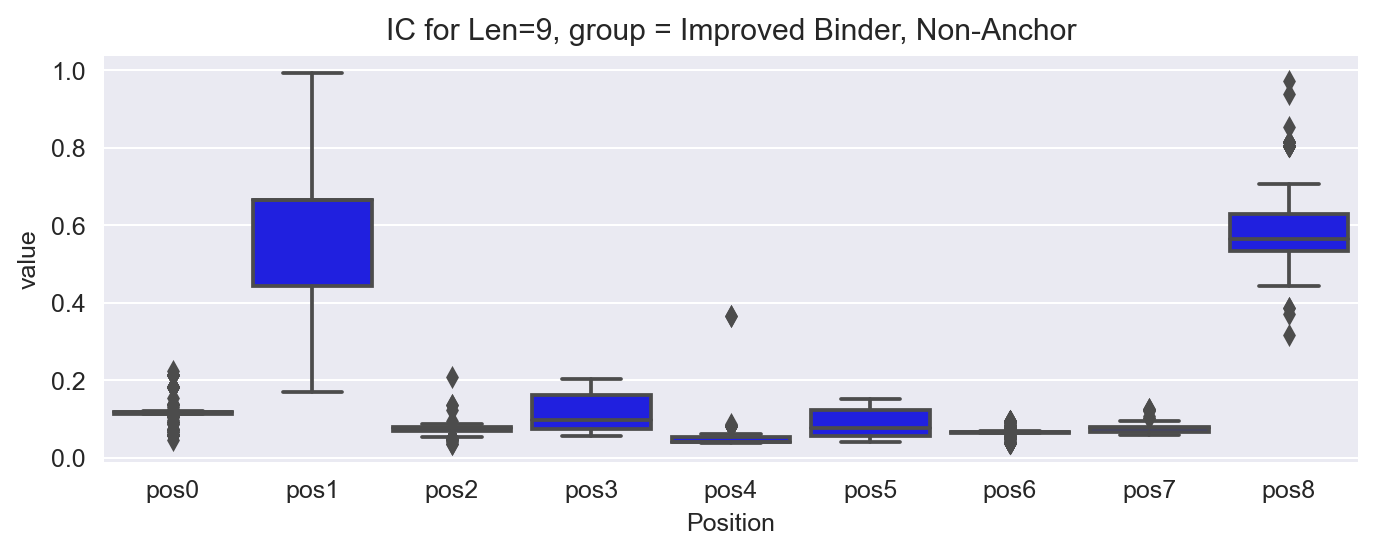

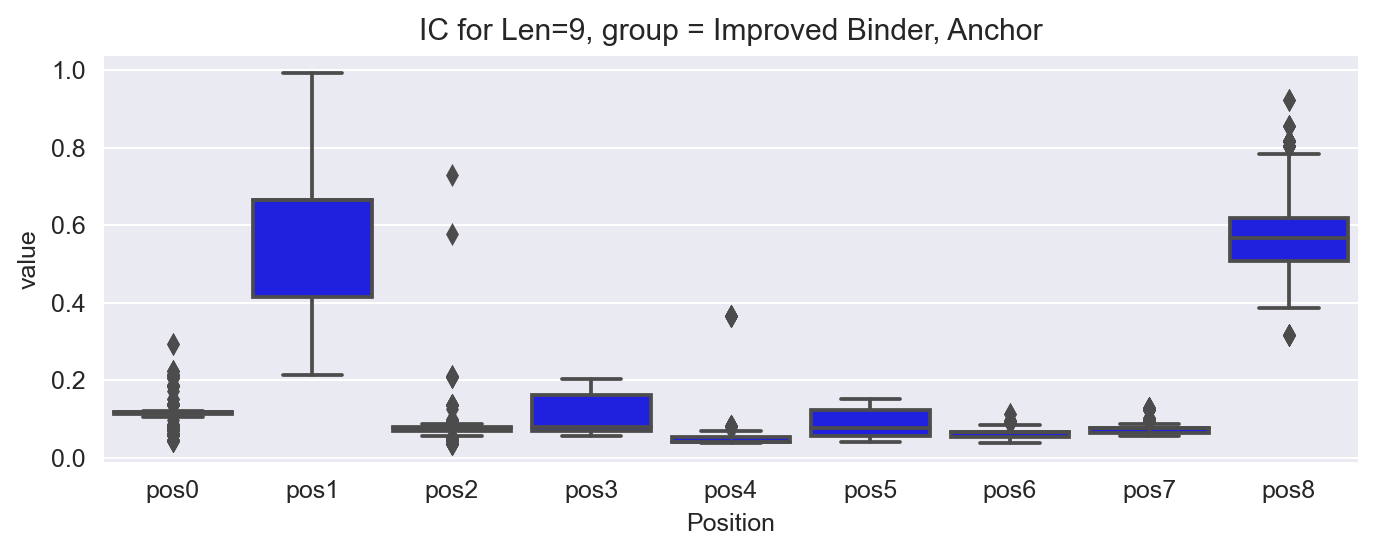

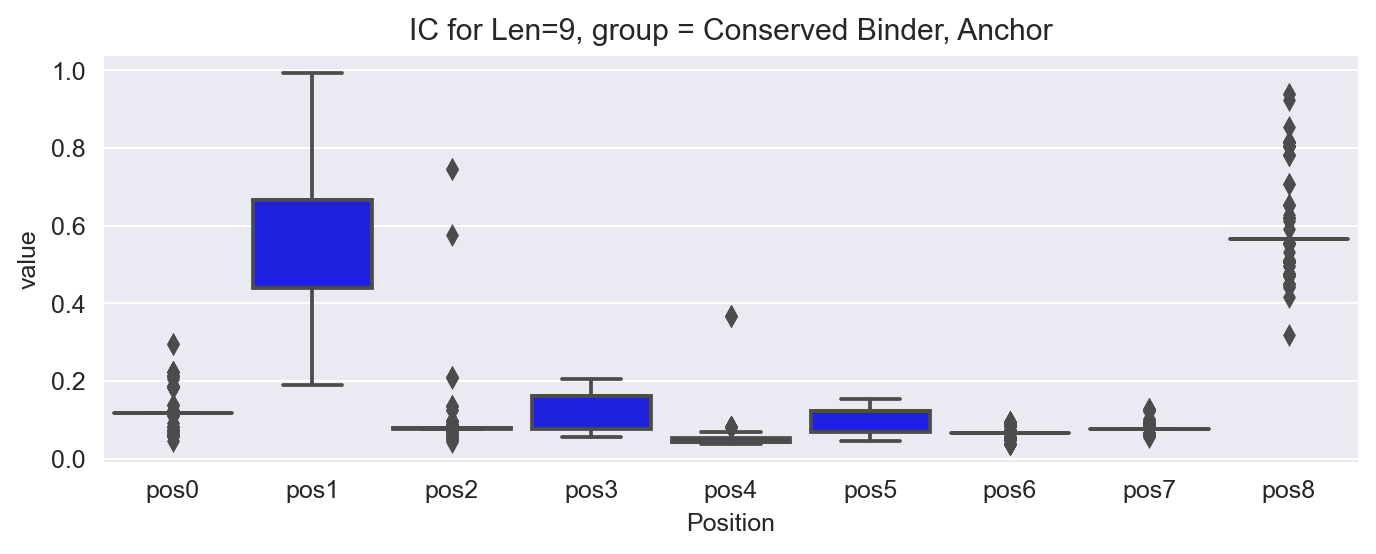

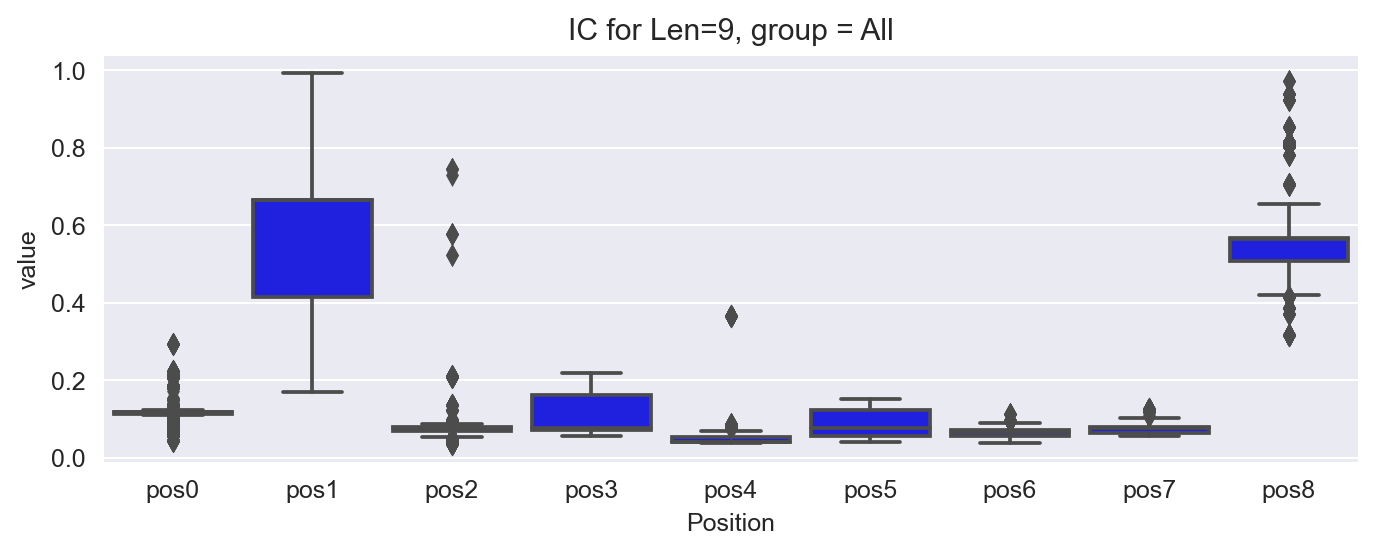

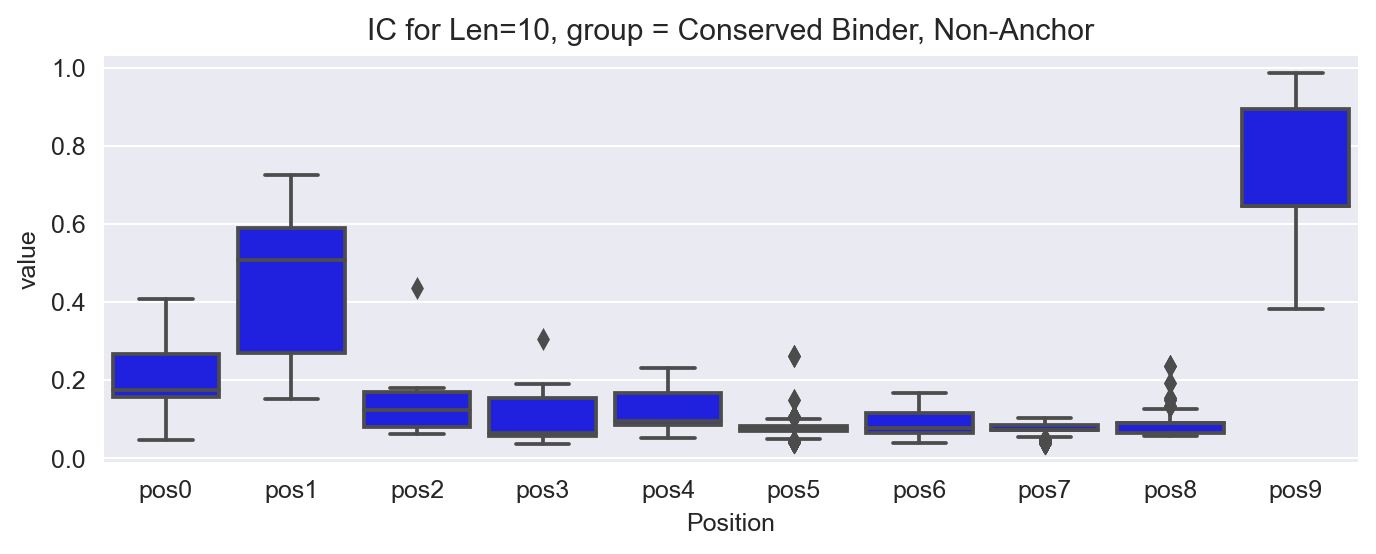

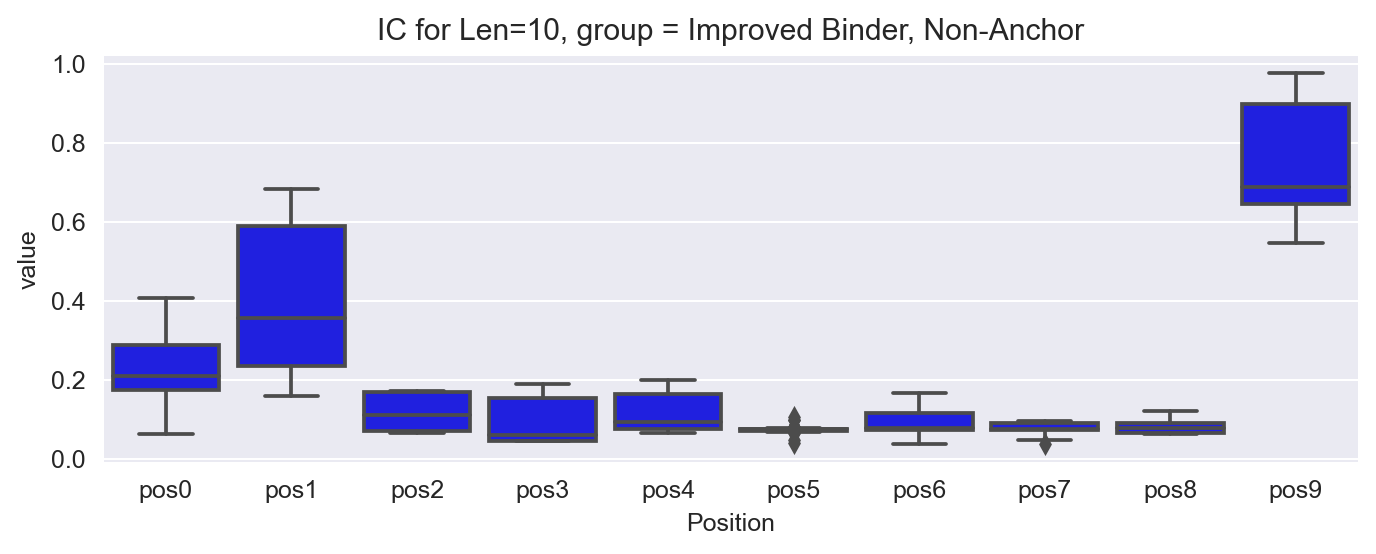

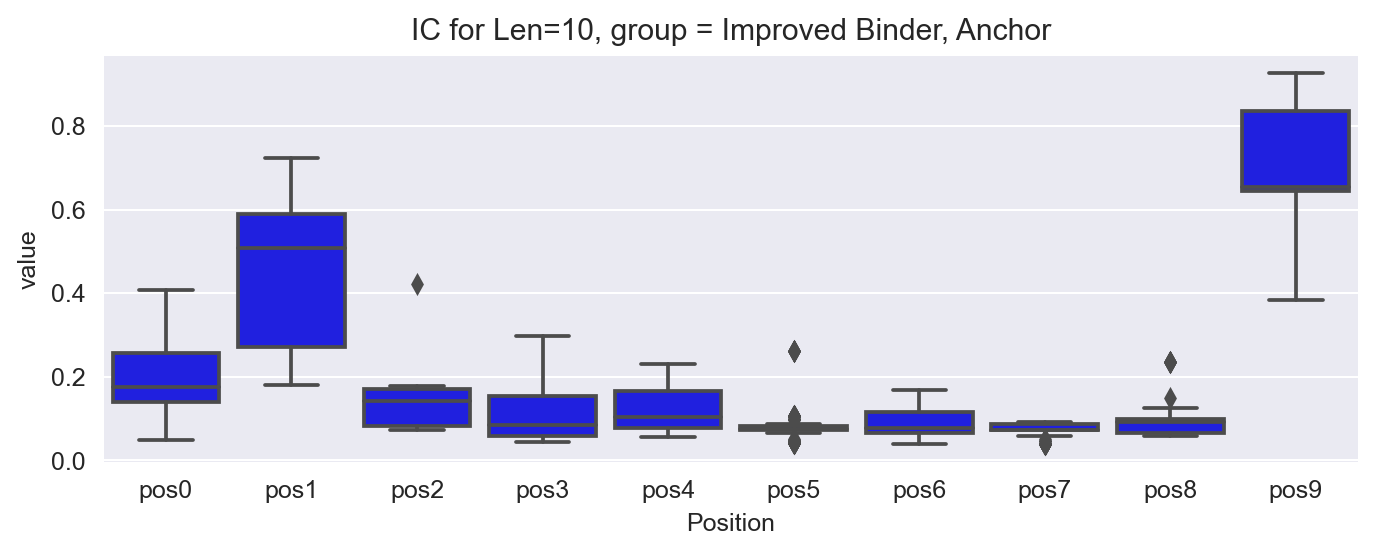

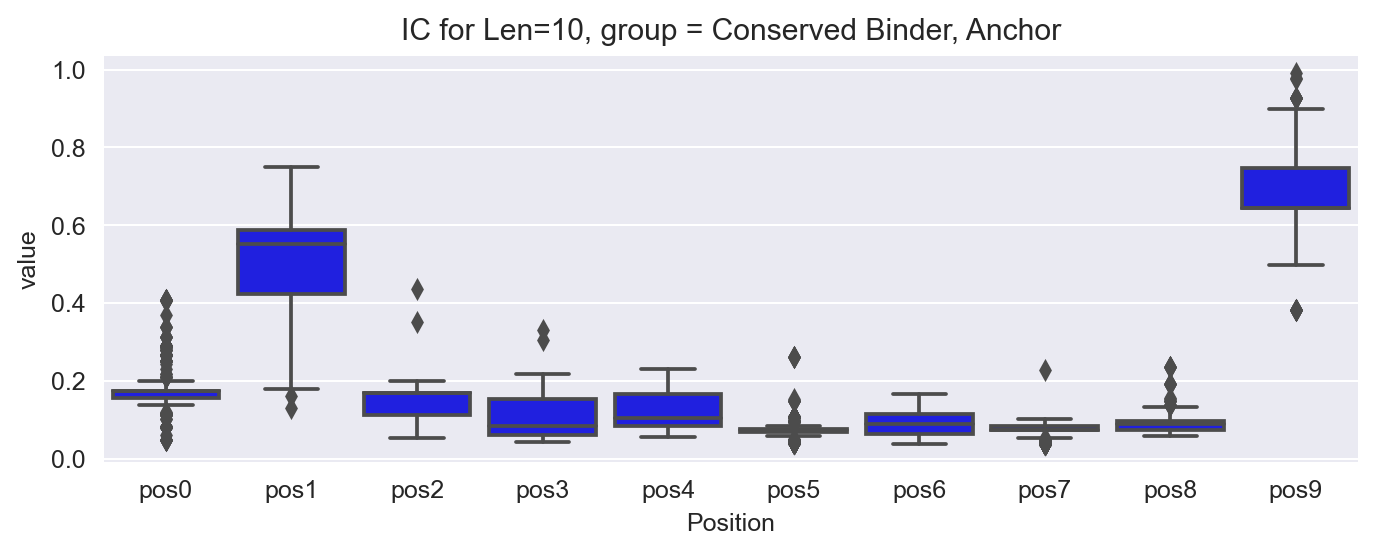

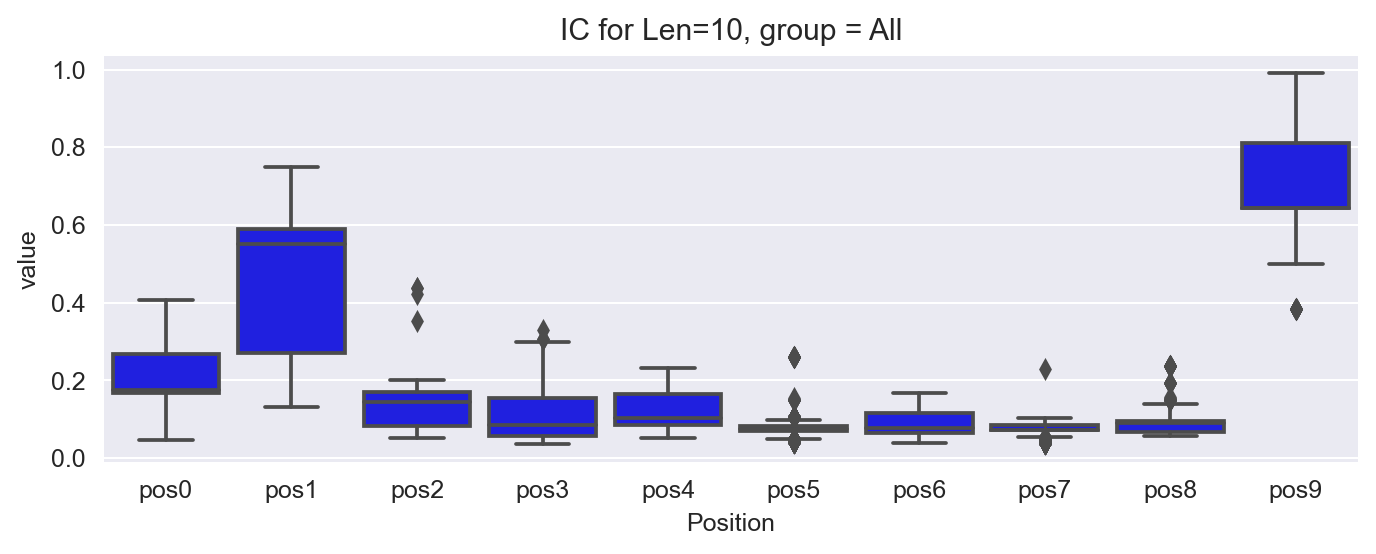

In [233]:
from src.data_processing import get_ic_weights

# IC profiles vs Weight profiles
results = {}
for len_ in [9, 10]:
    results[len_] = {}
    for group in list(cedar_related.BinderMutation.unique())+['All']:
        if group=='All':
            tmp = cedar_related.query('len==@len_')
        else:
            tmp = cedar_related.query('len==@len_ and BinderMutation==@group')
        ics = get_ic_weights(tmp, ics_kl, max_len = len_, invert=True)[:,:,0] # This is the "inverted" weight which is the IC
        weights = 1-ics # This is the "normal weight" used (1-ics)
        results[len_][group]={}
        results[len_][group]['IC'] = ics
        results[len_][group]['Weight'] = weights
        
        # Plotting IC
        df_ics = pd.DataFrame(ics, columns = [f'pos{k}' for k in range(len_)])
        f,a = plt.subplots(1,1, figsize=(9,3))
        sns.boxplot(data=df_ics.melt(), x='variable', y='value', color='b', ax=a, dodge=False, width=.85)
        a.set_title(f'IC for Len={len_}, group = {group}')
        a.set_xlabel('Position')
        f.savefig(f"../ics_len_{len_}_group_{group.replace(',','').replace(' ','')}")
        # Plotting weight
        # df_weights = pd.DataFrame(weights, columns = [f'pos{k}' for k in range(len_)])
        # f,a = plt.subplots(1,1, figsize=(9,3))
        # sns.boxplot(data=df_weights.melt(), x='variable', y='value', color='b', ax=a, dodge=False, width=.85)
        # a.set_title(f'Weights (1-IC) for Len={len_}, group = {group}')
        # a.set_xlabel('Position')
        # f.savefig(f"../weights_len_{len_}_group_{group.replace(',','').replace(' ','')}")

# Baseline HLA model check

In [267]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
enc=OneHotEncoder()
enc.fit(cedar.HLA.unique().reshape(-1,1))
enc.transform(cedar.sample(3).HLA.values.reshape(-1,1))

<3x63 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

## redef eval fct to use hla encoding as features

In [268]:
cedar_related.HLA.apply(lambda x : x[:7]+':'+x[7:]).values

array(['HLA-B07::02', 'HLA-B07::02', 'HLA-A02::01', ..., 'HLA-A24::02',
       'HLA-A24::02', 'HLA-A24::02'], dtype=object)

In [269]:
from joblib import Parallel, delayed
from functools import partial 
def get_predictions_hla(df, models, encoder):
    """

    Args:
        models (list) : list of all the models for a given fold. Should be a LIST
        ics_dict (dict): weights or None
        encoding_kwargs: the kwargs needed to process the df
        metrics (dict):

    Returns:
        predictions_df (pd
        df (pd.DataFrame): DataFrame containing the Peptide-HLA pairs to evaluate
        models (list): A.DataFrame): Original DataFrame + a column predictions which are the scores + y_true
    """
    # HERE NEED TO DO SWITCH CASES
    x, y = encoder.transform(df.HLA.values.reshape(-1,1)), df['agg_label'].values

    average_predictions = [model.predict_proba(x)[:, 1] \
                               for model in models]
    average_predictions = np.mean(np.stack(average_predictions), axis=0)
    output_df = df.copy(deep=True)
    output_df['pred'] = average_predictions
    return output_df

# EVAL WITH PARALLEL WRAPPER
def parallel_eval_wrapper_hla(test_dataframe, models_list, train_dataframe, encoder, fold_out):
    # If no train dataframe provided and test_dataframe is partitioned,
    # It will eval on each of the folds
    if 'fold' in test_dataframe.columns and test_dataframe.equals(train_dataframe):
        test_df = test_dataframe.query('fold==@fold_out')
    else:
        test_df = test_dataframe.copy().reset_index(drop=True)

    if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
        tmp = train_dataframe.query('fold != @fold_out')
        train_peps = tmp['Peptide'].unique()
        test_df = test_df.query(f'Peptide not in @train_peps')

    predictions_df = get_predictions_hla(test_df, models_list, encoder)
    test_metrics = get_metrics(predictions_df['agg_label'].values,
                               predictions_df['pred'].values)
    return predictions_df, test_metrics


def evaluate_trained_models_sklearn_hla(test_dataframe, models_dict, train_dataframe=None,
                                        concatenated=False, only_concat=False , encoder=OneHotEncoder()):

    # Wrapper and parallel evaluation
    eval_wrapper_ = partial(parallel_eval_wrapper_hla, test_dataframe=test_dataframe,
                            train_dataframe=train_dataframe, encoder=encoder)

    output = Parallel(n_jobs=len(models_dict.keys()))(delayed(eval_wrapper_)(fold_out=fold_out, models_list=models_list) \
                                                      for (fold_out, models_list) in tqdm(models_dict.items(),
                                                                                          desc='Eval Folds',
                                                                                          leave=False,
                                                                                          position=2))
    predictions_df = [x[0] for x in output]
    # print('here', len(predictions_df), len(predictions_df[0]))
    test_metrics = [x[1] for x in output]

    test_results = {k: v for k, v in zip(models_dict.keys(), test_metrics)}

    # Here simply concatenates it to get all the predictions from the folds
    predictions_df = pd.concat(predictions_df)

    # Here get the concat results
    if concatenated:
        test_results['concatenated'] = get_metrics(predictions_df['agg_label'].values,
                                                   predictions_df['pred'].values)
    # Either concatenated, or mean predictions
    else:
        # obj_cols = [x for x,y in zip(predictions_df.dtypes.index, predictions_df.dtypes.values) if y=='object']
        cols = ['Peptide', 'HLA', 'agg_label']
        mean_preds = predictions_df.groupby(cols).agg(mean_pred=('pred', 'mean'))
        predictions_df = test_dataframe.merge(mean_preds, left_on=cols, right_on=cols, suffixes=[None, None])
    # print('there', len(predictions_df))

    if only_concat and concatenated:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    return test_results, predictions_df



## runs

In [270]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from src.train_eval import get_predictions

rf = RandomForestClassifier(n_estimators=100, max_depth=5, ccp_alpha=4e-6)
encoder = OneHotEncoder(sparse=False)
encoder.fit(cedar.HLA.unique().reshape(-1,1))
models_dict = {}
for fold_out in tqdm(range(10)):
    models_dict[fold_out] = []
    inner_folds = [x for x in range(10) if x != fold_out]
    for fold_in in inner_folds:
        seed = fold_out*10+fold_in
        model=sklearn.base.clone(rf)
        model.set_params(random_state=seed)
        model = Pipeline([('scaler', StandardScaler()), ('model', model)])
        train = cedar.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
        valid = cedar.query('fold == @fold_in').reset_index(drop=True)
        x_train, y_train = encoder.transform(train.HLA.values.reshape(-1,1)), train['agg_label'].values
        x_valid, y_valid = encoder.transform(valid.HLA.values.reshape(-1,1)), valid['agg_label'].values
        model.fit(x_train, y_train)
         # Get the prediction values on both the train and validation set
        y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
        y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
        # Get the metrics and save them
        train_metrics = get_metrics(y_train, y_train_score, y_train_pred)
        valid_metrics = get_metrics(y_valid, y_val_score, y_val_pred)
        models_dict[fold_out].append(model)


  0%|          | 0/10 [00:00<?, ?it/s]

In [271]:
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
hlas = cedar.HLA.unique()
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')
cedar_related['HLA'] = cedar_related['HLA'].apply(lambda x: x[:7]+':'+x[7:])
prime_related['HLA'] = prime_related['HLA'].apply(lambda x: x[:7]+':'+x[7:])
prime_related = prime_related.query('HLA in @hlas')

cedar_results, cedar_df = evaluate_trained_models_sklearn_hla(cedar_related, models_dict, train_dataframe=cedar, concatenated=True, only_concat=True, encoder=encoder)
prime_results, prime_df = evaluate_trained_models_sklearn_hla(prime_related, models_dict, train_dataframe=cedar, concatenated=True, only_concat=True, encoder=encoder)

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [272]:
def tamerelapute(binder, anchor):
    anc_name = 'Anchor' if anchor else 'Non-Anchor'
    return binder+' Binder, '+anc_name
prime_df['BinderMutation'] = prime_df.apply(lambda x: tamerelapute(x['binder'], x['anchor_mutation']), axis=1)
cedar_df['BinderMutation'] = cedar_df.apply(lambda x: tamerelapute(x['binder'], x['anchor_mutation']), axis=1)

## plot

Text(0.5, 1.0, 'BEFORE rebalancing trainset ; Performance on test set (neoepitopes only)')

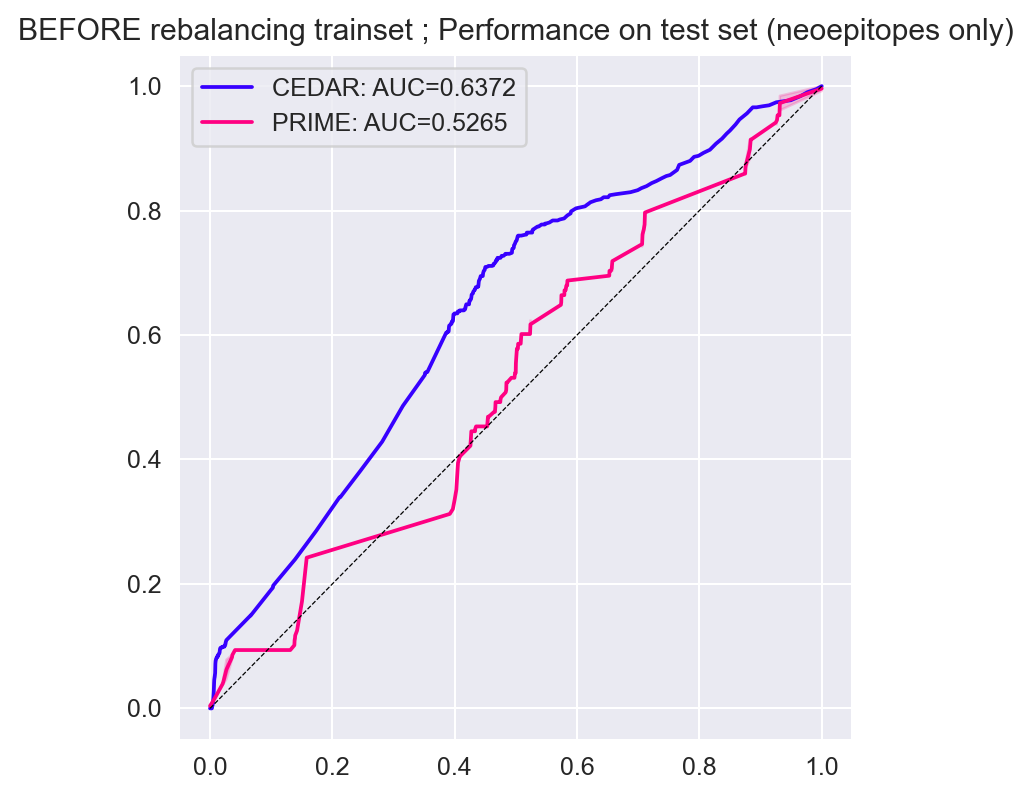

In [286]:
from sklearn.metrics import roc_auc_score, roc_curve
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(5,5))

cedar_tmp = cedar_df

n=len(cedar_tmp)
auc = roc_auc_score(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values).round(4)
fpr, tpr, _ = roc_curve(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values)
sns.lineplot(x=fpr, y=tpr, label = f'CEDAR: AUC={auc}', ax = a)

prime_tmp = prime_df.groupby(['Peptide', 'Allele']).mean()
auc = roc_auc_score(prime_tmp['agg_label'].values, prime_tmp['pred'].values).round(4)
fpr, tpr, _ = roc_curve(prime_tmp['agg_label'].values, prime_tmp['pred'].values)
sns.lineplot(x=fpr, y=tpr, label = f'PRIME: AUC={auc}', ax = a)
a.plot([0,1], [0,1], ls='--', lw=.5, c='k')
f.tight_layout(pad=3.5)
a.set_title('BEFORE rebalancing trainset ; Performance on test set (neoepitopes only)')

Text(0.5, 0.98, 'BEFORE rebalancing trainset ; Performance on test set (neoepitopes only)')

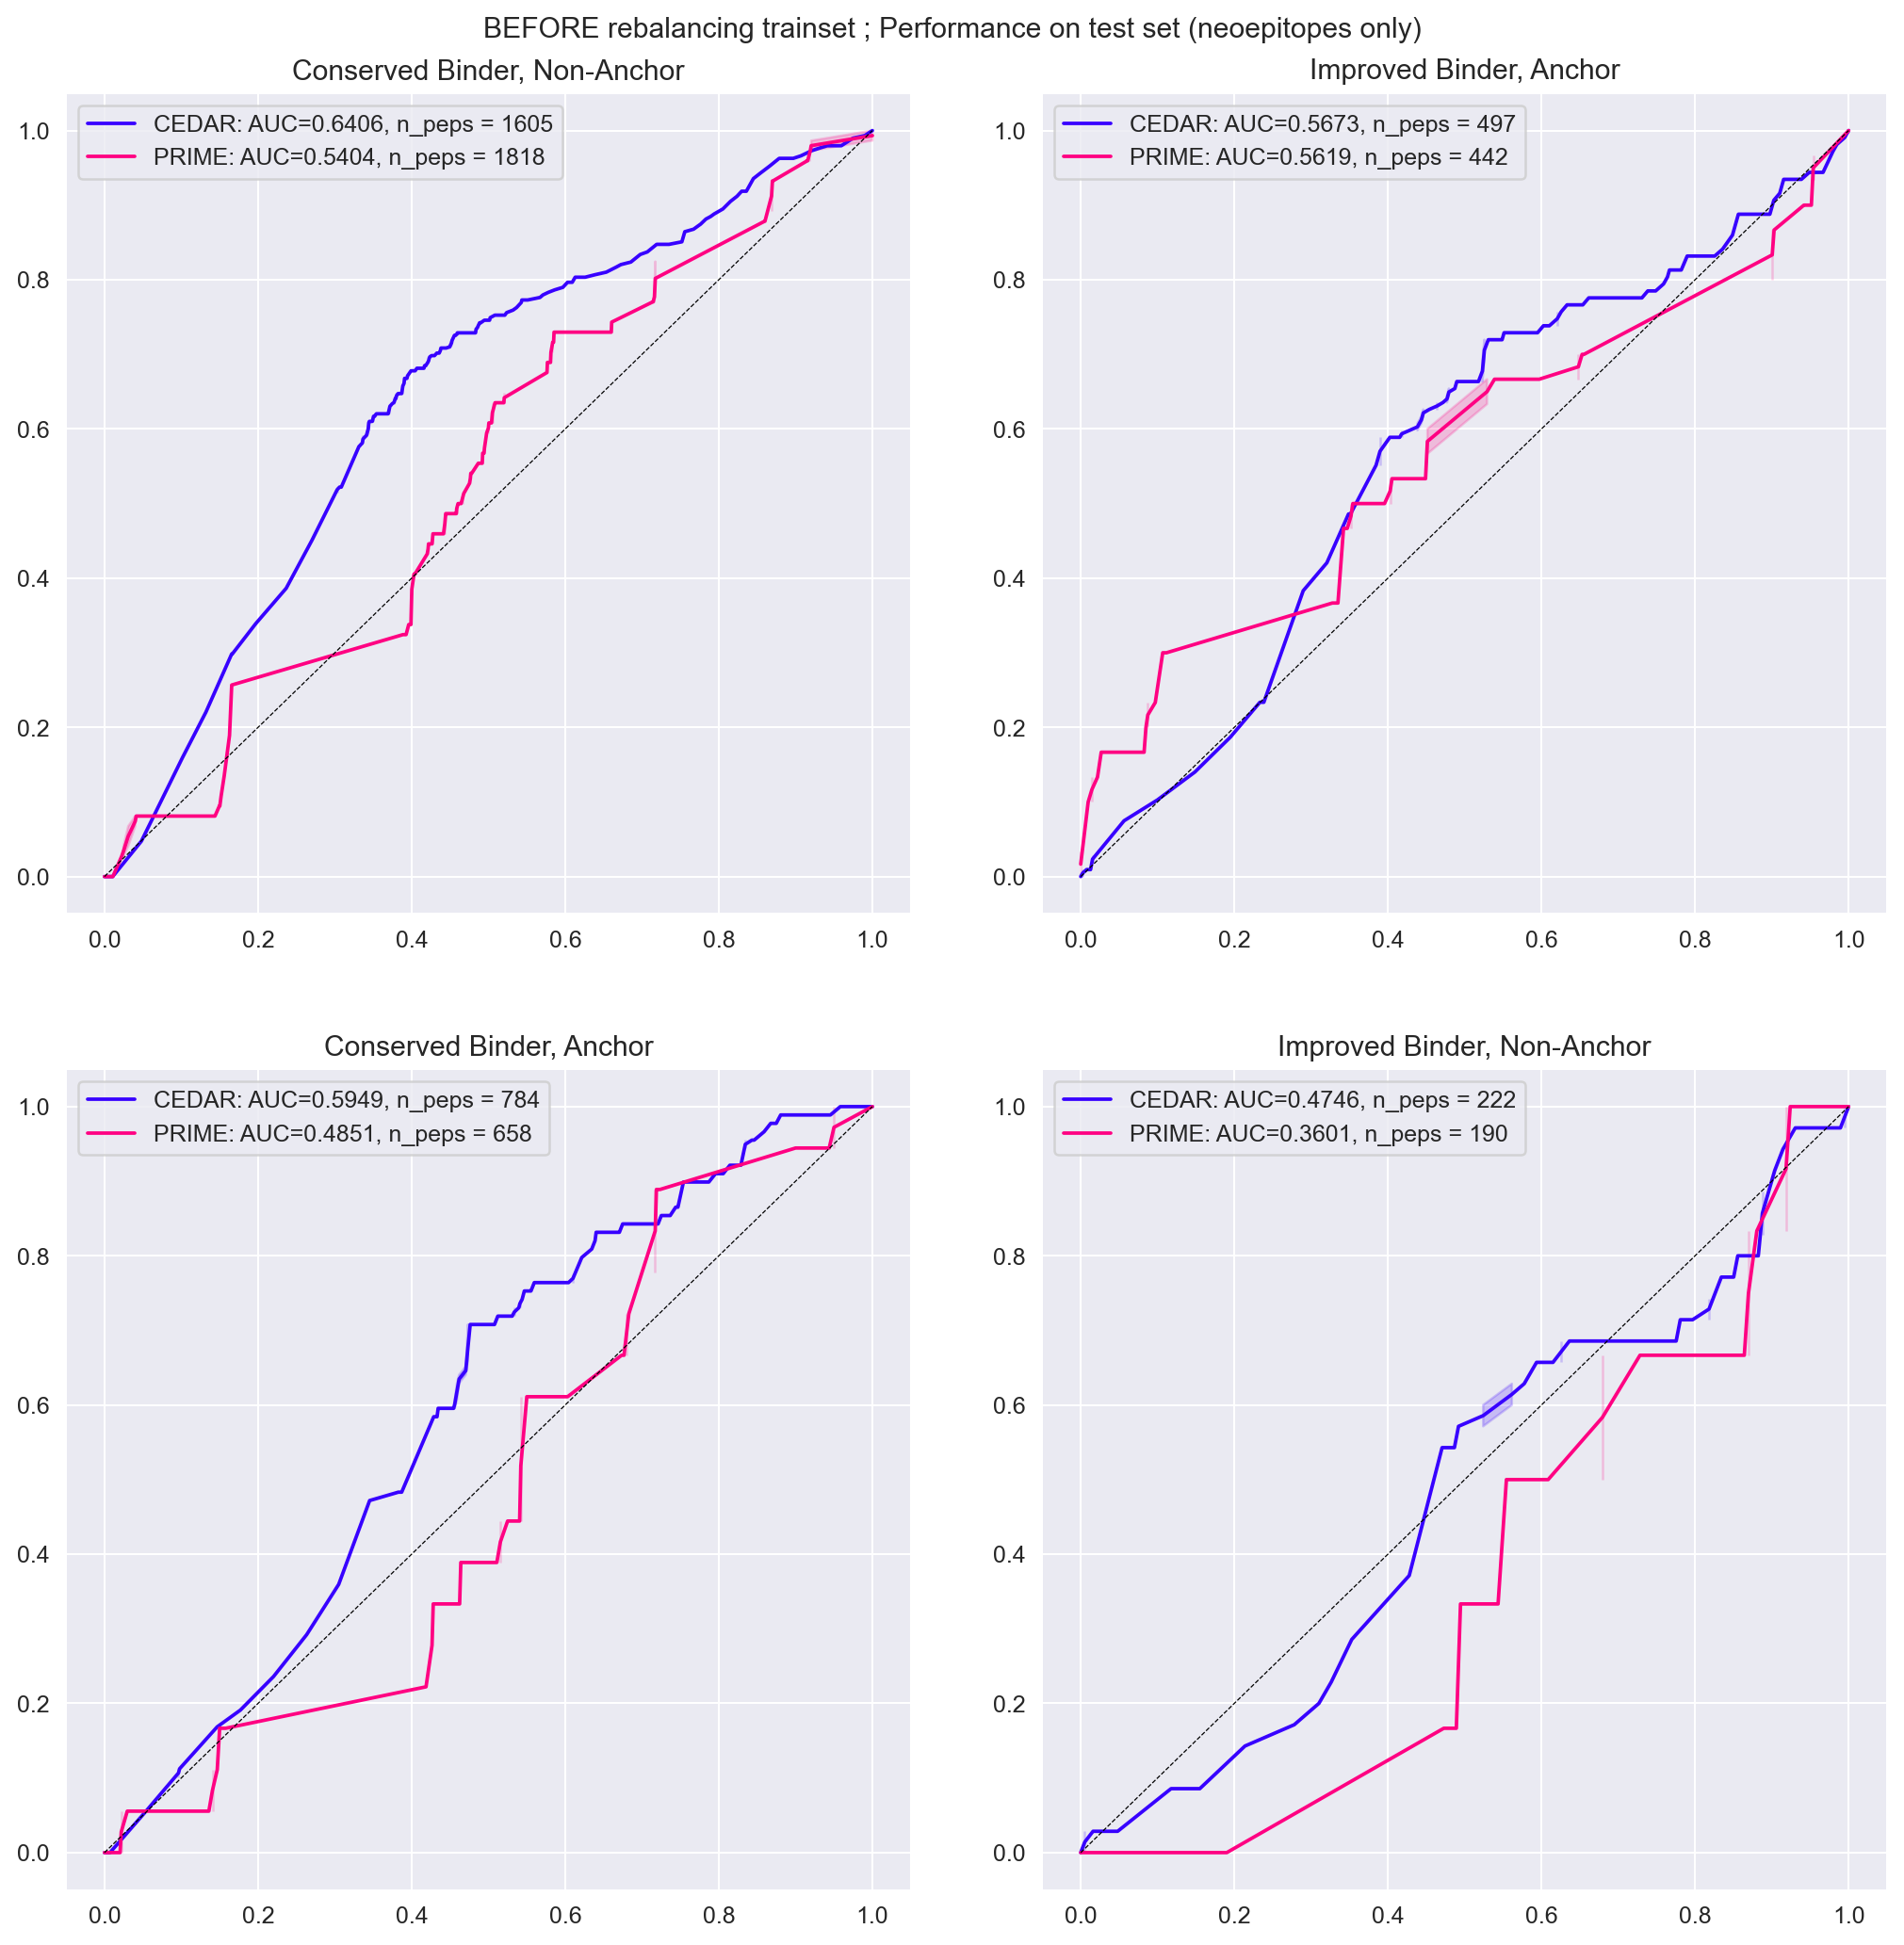

In [280]:
from sklearn.metrics import roc_auc_score, roc_curve
sns.set_palette(HSV)
f,a = plt.subplots(2,2, figsize=(12,12))
a = a.ravel()
for i,x in enumerate(cedar_df.BinderMutation.unique()):
    a[i].set_title(x)
    cedar_tmp = cedar_df.query('BinderMutation==@x and HLA not in @hlas_not')
    
    n=len(cedar_tmp)
    auc = roc_auc_score(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values).round(4)
    fpr, tpr, _ = roc_curve(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values)
    sns.lineplot(x=fpr, y=tpr, label = f'CEDAR: AUC={auc}, n_peps = {n}', ax = a[i])
    
    prime_tmp = prime_df.query('BinderMutation==@x').groupby(['Peptide', 'Allele']).mean()
    n=len(prime_tmp)
    auc = roc_auc_score(prime_tmp['agg_label'].values, prime_tmp['pred'].values).round(4)
    fpr, tpr, _ = roc_curve(prime_tmp['agg_label'].values, prime_tmp['pred'].values)
    sns.lineplot(x=fpr, y=tpr, label = f'PRIME: AUC={auc}, n_peps = {n}', ax = a[i])
    a[i].plot([0,1], [0,1], ls='--', lw=.5, c='k')
f.tight_layout(pad=3.5)
f.suptitle('BEFORE rebalancing trainset ; Performance on test set (neoepitopes only)')

# REDO Baseline HLA model check with the new "balanced" dataset

In [266]:
cedar_hp_fold = pd.read_csv('../data/partitioned_traindata/cedar_hp_fold_balanced.csv')

## runs

In [256]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from src.train_eval import get_predictions

rf = RandomForestClassifier(n_estimators=100, max_depth=5, ccp_alpha=4e-6)
encoder = OneHotEncoder(sparse=False)
encoder.fit(cedar_hp_fold.HLA.unique().reshape(-1,1))
models_dict = {}
for fold_out in tqdm(range(10)):
    models_dict[fold_out] = []
    inner_folds = [x for x in range(10) if x != fold_out]
    for fold_in in inner_folds:
        seed = fold_out*10+fold_in
        model=sklearn.base.clone(rf)
        model.set_params(random_state=seed)
        model = Pipeline([('scaler', StandardScaler()), ('model', model)])
        train = cedar_hp_fold.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
        valid = cedar_hp_fold.query('fold == @fold_in').reset_index(drop=True)
        x_train, y_train = encoder.transform(train.HLA.values.reshape(-1,1)), train['agg_label'].values
        x_valid, y_valid = encoder.transform(valid.HLA.values.reshape(-1,1)), valid['agg_label'].values
        model.fit(x_train, y_train)
         # Get the prediction values on both the train and validation set
        y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
        y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
        # Get the metrics and save them
        train_metrics = get_metrics(y_train, y_train_score, y_train_pred)
        valid_metrics = get_metrics(y_valid, y_val_score, y_val_pred)
        models_dict[fold_out].append(model)


  0%|          | 0/10 [00:00<?, ?it/s]

In [262]:
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
hlas = cedar.HLA.unique()
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')
cedar_related['HLA'] = cedar_related['HLA'].apply(lambda x: x[:7]+':'+x[7:])
prime_related['HLA'] = prime_related['HLA'].apply(lambda x: x[:7]+':'+x[7:])
prime_related = prime_related.query('HLA in @hlas')

_, cedar_df_balanced = evaluate_trained_models_sklearn_hla(cedar_related, models_dict, train_dataframe=cedar_hp_fold, concatenated=True, only_concat=True, encoder=encoder)
_, prime_df_balanced = evaluate_trained_models_sklearn_hla(prime_related, models_dict, train_dataframe=cedar_hp_fold, concatenated=True, only_concat=True, encoder=encoder)

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [263]:
def tamerelapute(binder, anchor):
    anc_name = 'Anchor' if anchor else 'Non-Anchor'
    return binder+' Binder, '+anc_name
prime_df_balanced['BinderMutation'] = prime_df.apply(lambda x: tamerelapute(x['binder'], x['anchor_mutation']), axis=1)
cedar_df_balanced['BinderMutation'] = cedar_df.apply(lambda x: tamerelapute(x['binder'], x['anchor_mutation']), axis=1)

## plot

Text(0.5, 1.0, 'AFTER rebalancing trainset ; Performance on test set (neoepitopes only)')

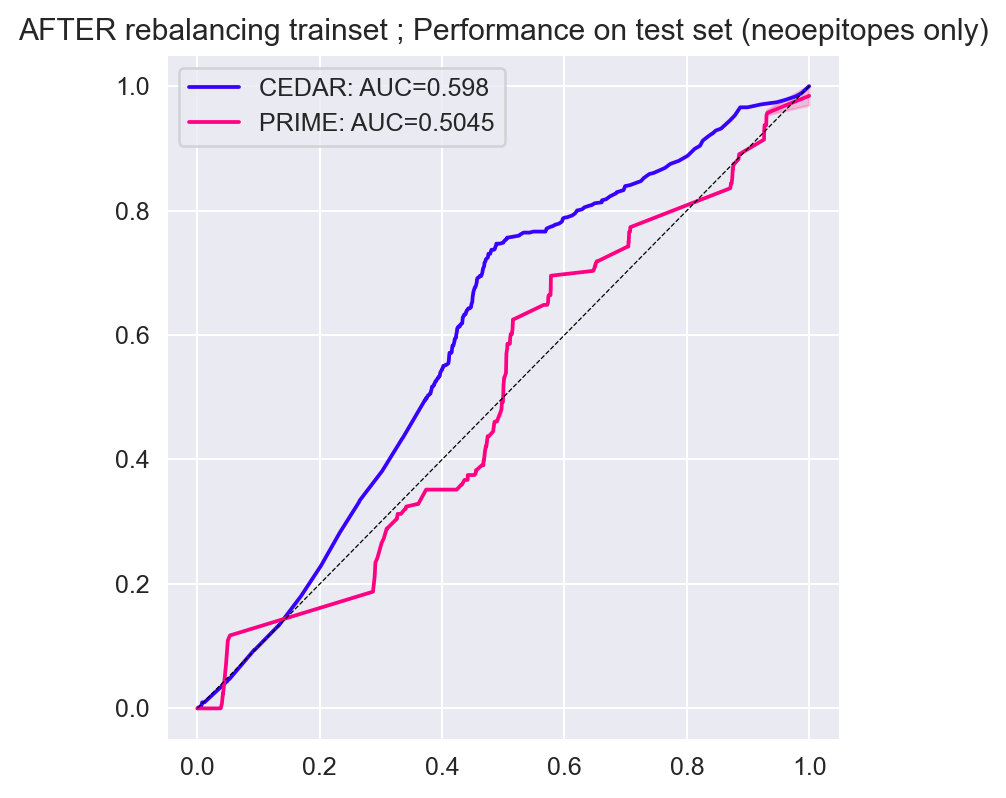

In [285]:
from sklearn.metrics import roc_auc_score, roc_curve
sns.set_palette(HSV)
f,a = plt.subplots(1,1, figsize=(5,5))

cedar_tmp = cedar_df_balanced

n=len(cedar_tmp)
auc = roc_auc_score(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values).round(4)
fpr, tpr, _ = roc_curve(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values)
sns.lineplot(x=fpr, y=tpr, label = f'CEDAR: AUC={auc}', ax = a)

prime_tmp = prime_df_balanced.groupby(['Peptide', 'Allele']).mean()
auc = roc_auc_score(prime_tmp['agg_label'].values, prime_tmp['pred'].values).round(4)
fpr, tpr, _ = roc_curve(prime_tmp['agg_label'].values, prime_tmp['pred'].values)
sns.lineplot(x=fpr, y=tpr, label = f'PRIME: AUC={auc}', ax = a)
a.plot([0,1], [0,1], ls='--', lw=.5, c='k')
f.tight_layout(pad=3.5)
a.set_title('AFTER rebalancing trainset ; Performance on test set (neoepitopes only)')

Text(0.5, 0.98, 'AFTER rebalancing trainset ; Performance on test set (neoepitopes only)')

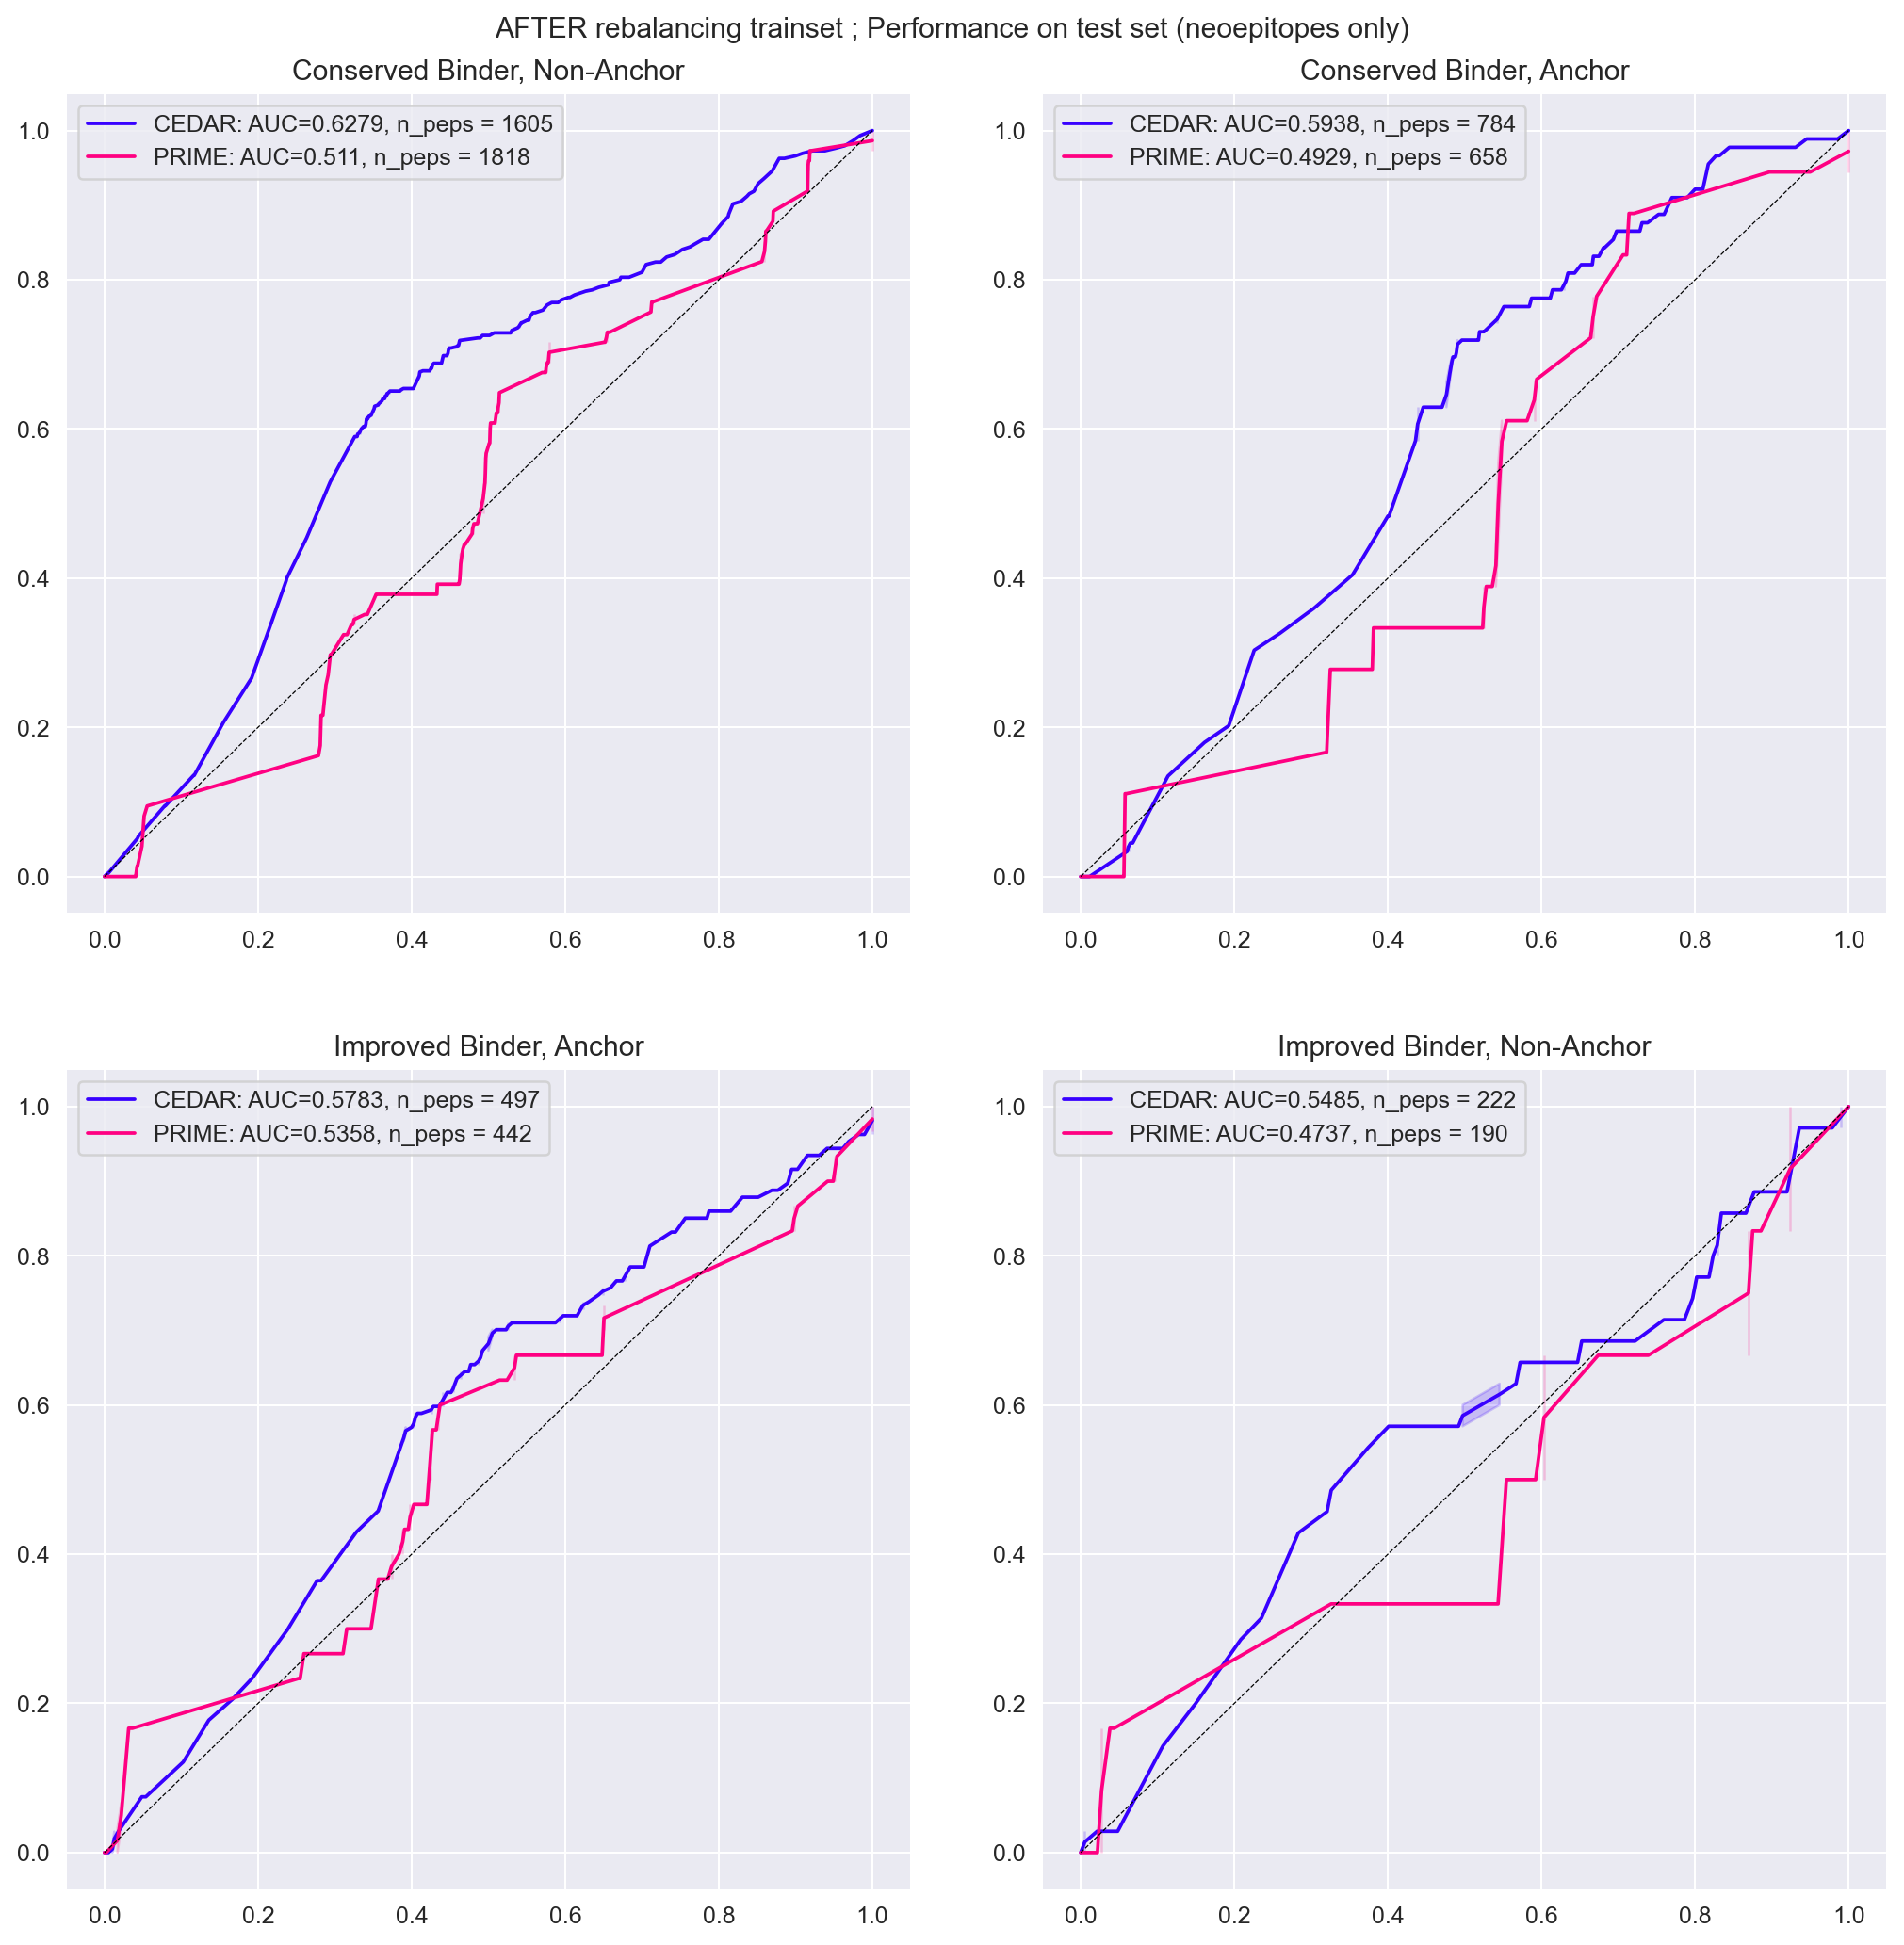

In [281]:
from sklearn.metrics import roc_auc_score, roc_curve
sns.set_palette(HSV)
f,a = plt.subplots(2,2, figsize=(12,12))
a = a.ravel()
for i,x in enumerate(cedar_df_balanced.BinderMutation.unique()):
    a[i].set_title(x)
    cedar_tmp = cedar_df_balanced.query('BinderMutation==@x and HLA not in @hlas_not')
    
    n=len(cedar_tmp)
    auc = roc_auc_score(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values).round(4)
    fpr, tpr, _ = roc_curve(cedar_tmp['agg_label'].values, cedar_tmp['pred'].values)
    sns.lineplot(x=fpr, y=tpr, label = f'CEDAR: AUC={auc}, n_peps = {n}', ax = a[i])
    
    prime_tmp = prime_df_balanced.query('BinderMutation==@x').groupby(['Peptide', 'Allele']).mean()
    n=len(prime_tmp)
    auc = roc_auc_score(prime_tmp['agg_label'].values, prime_tmp['pred'].values).round(4)
    fpr, tpr, _ = roc_curve(prime_tmp['agg_label'].values, prime_tmp['pred'].values)
    sns.lineplot(x=fpr, y=tpr, label = f'PRIME: AUC={auc}, n_peps = {n}', ax = a[i])
    a[i].plot([0,1], [0,1], ls='--', lw=.5, c='k')
f.tight_layout(pad=3.5)
f.suptitle('AFTER rebalancing trainset ; Performance on test set (neoepitopes only)')

# Data Processing

In [10]:
# TODO : NEED TO IMPLEMENT "ADAPTIVE" WEIGHTING FOR ANCHOR/NON ANCHOR MUTATION
# At the moment, just include Anchor/NonAnchor as features (0, 1)
from src.data_processing import get_freq_tensors, get_mutation_tensors, get_array_dataset, BL62_VALUES, BL62FREQ_VALUES, encode_batch_weighted
train = dataset.query('fold!=0 and fold !=1')
valid = dataset.query('fold==1')
test = dataset.query('fold==0')

In [11]:
xxx = encode_batch_weighted(test, ics_kl, None, 12, 'blosum', BL62_VALUES)
xxx.shape

torch.Size([296, 12, 20])

In [12]:
xmut = encode_batch_weighted(test, ics_kl, None, 12, 'blosum', BL62_VALUES).view(-1,12*20)
xwt = encode_batch_weighted(test, ics_kl, None, 12, 'blosum', BL62_VALUES, seq_col='wild_type').view(-1,12*20)
xfeats = torch.from_numpy(test[feature_columns].values)
xmut.shape, xwt.shape, xfeats.shape

(torch.Size([296, 240]), torch.Size([296, 240]), torch.Size([296, 14]))

In [26]:
from src.data_processing import get_tensor_dataset
x,y = get_tensor_dataset(test, ics_kl, 'cuda', 'mutation', 12, 'onehot', None, feat_cols = feature_columns, invert=True)
print(x.shape, y.shape)
x,y = get_tensor_dataset(test, ics_kl, 'cuda', 'aafreq', 12, 'onehot', None, feat_cols = feature_columns, invert=True)
print(x.shape, y.shape)

torch.Size([296, 494]) torch.Size([296, 1])
torch.Size([296, 20]) torch.Size([296, 1])


In [14]:
x.shape

torch.Size([296, 494])

**MODIFY GET_TENSOR_DATASET TO TAKE AS ARGUMENT "DATASET" WITH CASES AA_FREQ (OLD BEHAVIOUR) OR MUTATION (NEW DUAL INPUT BEHAVIOUR)**

# Model & Runs

## Model Def

In [288]:
dataset.columns

Index(['Peptide', 'HLA', 'trueHLA_EL_rank', 'agg_label', 'fold', 'BA_rank',
       'BA_score', 'BinderMutation', 'HLA_full', 'PMIDs',
       'Related Object_Ending Position', 'Related Object_Starting Position',
       'anchor_mutation', 'binder', 'core', 'core_mutation_position',
       'delta_VHSE1', 'delta_VHSE3', 'delta_VHSE7', 'delta_VHSE8',
       'delta_aliphatic_index', 'delta_boman', 'delta_hydrophobicity',
       'delta_isoelectric_point', 'delta_rank', 'icore', 'label', 'len',
       'len_wt', 'mhc_anchor', 'mutation', 'mutation_position',
       'mutation_score', 'mutation_type', 'percentage_pos', 'pred_EL_rank',
       'pred_EL_score', 'pred_HLA', 'rank_ratio', 'responses', 'total_count',
       'trainset', 'wild_type', 'wt_EL_rank', 'wt_core', 'wt_true'],
      dtype='object')

In [20]:
from src.models import Standardizer, ConvBlock, DICNN, NetWrapper
x_props = x[:, -14:]
nw = NetWrapper(12, 10, 30, 14)
print(nw.standardizer.mu)
nw.standardizer.fit(x_props)
print(nw.standardizer.mu)
nw.reset_parameters(seed=2)
print(nw.standardizer.mu)

0
tensor([ 0.4392,  0.0441,  0.0484, -0.0322, -0.0659,  4.8216, -0.1694,  0.1214,
         0.0865,  2.7635,  1.0087, 15.6234,  1.6070,  4.3705], device='cuda:0')
0


In [27]:
hasattr(nw, 'standardizer')

True

In [22]:
nw.standardizer.fit(x_props)
nw.to(device)
nw(x).shape

torch.Size([14]) torch.Size([296, 14])


torch.Size([296, 1])

In [24]:
issubclass(nw.__class__, nn.Module)

True

In [25]:
rf = LogisticRegression()
issubclass(rf.__class__, sklearn.base.BaseEstimator)

True

## Pipeline
TODO:
Adapt the current pipeline & change the train / eval fct to return prediction dfs and use the new encoding with mutation_tensors

- Change data processing / Loading in train/eval fct

- Deal with extra features std

- Change model handling and/or concatenate